***Handling Seismic Data (SEGY)***

by : leocd91@gmail.com

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/1nDTLksdQOaCWY3I5OK9c_aTqboIZg5gA">
        <img src="https://i.ibb.co/3723Hm9/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/leocd91/geodatahandling">
        <img src="https://i.ibb.co/L5p10GH/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# **Introduction** (you can read it or skip it)


---
Welcome to the second episode of "***Digital Geoscience Data Handling using Python***" Series.
During this physical-distancing-new-normal year, I try to compile my experiences in handling digital geoscience / petrotechnical data. 

This will include: Parsing any type of data, QC analysis, database, feeding data for geophysical inversion - machine learning / deep learning stuffs, and maybe handling those data to do some GP-GPU too.

I made this tutorial as beginner-friendly as possible, so some explanation might not be as "*cool & marketing-friendly*" as developers intended. 
And some code are not *pythonic* for that reason too.




any feedback just hmu.

---

**- Why don't we just install X to read those files?**

> Yes you can do that too. 

> This tutorial for those who wish how to parse any digital geoscience data content without dependencies. 
> People who work with geoscience data for some years often struggles with python package that evolve really fast which make their code obsolete quickly. Also some package use their own class/data-type which you will find challenging to inspect your own array.

**- Is there any Prereq.?**

> Just knowing basic stuff about programming is enough.
If you don't even know what an array is, I suggest watching some crash course python on youtube.

 **- Who are you giving some tutorials on the internet!?**

 

> I'm a Petrotechnical Data Management on a NOC in Indonesia. More than 5 years here and still going strong.

> I code my way to finish my undergraduate thesis (FDTD Elastic Wave in cuda) and get some side-gigs from there too (Inversion Method, Numerical Simulation, Etc.).

> I know some C, F95, and Matlab (Now I'm Python *Muallaf* tho).

> My main interest is in computational geophysics and GP-GPU.

> I also *(lazily)* wrote some stuff on my blog about computational geophysics here http://redigitize.blogspot.com/ 

> I also ***love*** deep-fried banana.
 

 
 **TL;DR** I'm not a PhD, CEO, or Someone famous. I'm just glad that I can share something that I learn and learn more from this.

**- Which Python or Software or IDE or whatever that means to learn python? What is this stuff called Notebook!? Even this google colab thing!?   I hate you!**


> Grab your towel and don't panic! 
> You can use this stuff inside google colab thing which people usually call by "notebook format", it's easy to make a step-by-step tutorial here. Also to run your specific line of code you just have to click the "play" button (it's actually RUN button tho) on the left.

> Try this one below!





In [ ]:
print("hello stranger, what are you buyin'?") #click run button on the left and see result below.

hello stranger, what are you buyin'?



> As for what "*software*" to use, For me, I rarely use a notebook, some people that prefer IDE or Editor type of python use pycharm (https://www.jetbrains.com/pycharm/) or SPYDER (https://www.spyder-ide.org/) (for former Matlab user, maybe spyder is your favorite editor. It got variable explorer!)

**TL;DR** you can use google colab notebook or install pycharm or install anaconda (got spyder and stuff installed in your pc already like google colab)

---

#**SEGY Data: Understanding their Binary Format**

---
Let's try to parse seismic data from the SEGY file!

---


**What data to use?**

You can try to download open data below from USGS, change to your own url, or upload your own data here using folder icon in the left.

---

In [ ]:
!wget http://certmapper.cr.usgs.gov/data/NPRA/seismic/1981/31_81/PROCESSED/31_81_PR.SGY

#open alaska data from #https://wiki.seg.org/wiki/Alaska_2D_land_line_31-81

--2021-06-23 01:45:12--  http://certmapper.cr.usgs.gov/data/NPRA/seismic/1981/31_81/PROCESSED/31_81_PR.SGY
Resolving certmapper.cr.usgs.gov (certmapper.cr.usgs.gov)... 137.227.229.75, 2001:49c8:8000:121d::1075
Connecting to certmapper.cr.usgs.gov (certmapper.cr.usgs.gov)|137.227.229.75|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://certmapper.cr.usgs.gov:443/data/NPRA/seismic/1981/31_81/PROCESSED/31_81_PR.SGY [following]
--2021-06-23 01:45:12--  https://certmapper.cr.usgs.gov/data/NPRA/seismic/1981/31_81/PROCESSED/31_81_PR.SGY
Connecting to certmapper.cr.usgs.gov (certmapper.cr.usgs.gov)|137.227.229.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3337896 (3.2M) [application/seismic-segy]
Saving to: ‘31_81_PR.SGY’

31_81_PR.SGY        100%[===================>]   3.18M  7.51MB/s    in 0.4s    

2021-06-23 01:45:13 (7.51 MB/s) - ‘31_81_PR.SGY’ saved [3337896/3337896]



---
Just like the last episode, first let's <strike>summon our Dark Lord</strike> call some common modules using command below.

Also let's try to set pandas because we will need some large table to show our data.

---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os                       #OS module in Python provides functions for interacting with the operating system.

pd.set_option('max_rows', 99999) #we change the view setting of pandas because handling lot of data
pd.set_option('max_colwidth', 400) 
%load_ext google.colab.data_table

---
**"What's the OS stuff?"**


> OS module in Python provides functions for interacting with the operating system. We can get info from the file like their size, time modified, etc.

Let's try to open the file and get it's size.



---

In [ ]:
filename='31_81_PR.SGY'
file_size = os.stat(filename)[6]  #getting the 7th value of what os.stat get, which is st_size or file size in bytes
                                  #for more info : https://www.geeksforgeeks.org/python-os-stat-method/ 
print("file name : ",filename)
print("file size : ",file_size , " bytes")

file name :  31_81_PR.SGY
file size :  3337896  bytes


---
**"Why do we need the file size?"**

That's because SEGY is a binary file. 

> A binary file is a file stored in binary format. *duh*

ELI5, Binary format is a 1-D series of 0 and 1 in a group of eight ( for example '01010101') which called a byte.

This website got really nice simple explanation about what a binary file is : https://betterexplained.com/articles/a-little-diddy-about-binary-file-formats/

And for a SEGY data, that series of data is formatted like this.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/SEGY_file_byte_stream_structure.svg/733px-SEGY_file_byte_stream_structure.svg.png)

And as why you need the filesize, it's because you can only calculate some information like the number of traces (which in pic above stated as `m`) by knowing the filesize.

**"So How do you know where each certain position of seismic information and data in the binary file?"**

SEG got it all documented here : 

>www.seg.org/documents/10161/77915/seg_y_rev1.pdf

>https://seg.org/Portals/0/SEG/News%20and%20Resources/Technical%20Standards/seg_y_rev2_0-mar2017.pdf

Using those documentation as a clue, Let's dive in!

First, open the SEGY file.


In [ ]:
f = open(filename, 'rb')                        # open the file

---
Then, Let's parse all of the info and data from each section of SEGY file:
1. Textual Header
2. 400-byte Binary Header
3. 240-byte Trace Headers
4. Trace Data (the seismic recording itself)

---

#**Textual header, 400-byte Header, 240-byte Trace Header :** So many headers!

---
Well we paid so much for seismic acquisition, why don't we just add everything there :))

Alright, let's get those important infos.

---


In reading a binary files, to get certain value its generally like this:
1. open the file
2. go to byte position you want
3. read for specific byte size
4. decode it from binary format to certain value format (int, float, string, etc)

Let's try it out first by getting the number of sample of each trace from the SEGY.

If you read the documentation (www.seg.org/documents/10161/77915/seg_y_rev1.pdf), 

it's on the 3221th byte of the file.

---

In [ ]:
f.seek(3220,0)                                  # Locate our position to 3221th byte of file
data = f.read(2)                                # Read 2 byte from our position
tr_sample=int.from_bytes(data, byteorder='big') # decode our binary into int
print("no. of trace sample : ", tr_sample)     

no. of trace sample :  1501


---
That what you have to do to get everything you want in a SEGY file.

Let's start with the textual header first.

---

**Textual Header handling**
---
Textual header is the first 3200-byte size record that contains 40 lines (with each 80 length of character) of textual information, providing a human-readable description of the seismic data of the SEG Y file. Commonly in a EBDCID format (https://en.wikipedia.org/wiki/EBCDIC). 

It's the easiest part of reading a SEGY file.

Now let's parse it.

---

In [ ]:
f.seek(0,0)                 #Locate our position to first byte of file
data = f.read(3200)         #Read the first 3200 byte from our position
data = data.decode('cp500') #EBCDIC encoding source:https://kite.com/python/docs/encodings.cp500
n = 80                      #A textual header is made of 40x80 characters, we split the string every 80 char.
txt_header=[]               #Empty string list to put the splitted textual header
 
for i in range(0, len(data), n):  
  txt_header.append(data[i:i+n])  #splitting the data and put it to txt_header
 
for i in range(0,len(txt_header)):
  print(txt_header[i])              #print to see the content

C01 CLIENT/JOB ID    1 1 2 9 2 1 1 3                                            
C02 LINE    L31                                                                 
C03 REEL NO 810602112911   DAY-START OF REEL  02       YEAR 1981                
C04 INSTRUMENT: MFG TI          MODEL ASC                                       
C05 DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001  
C06 SAMPLE RATE   0000004000 US  SAMPLES/TRACE  1501BITS/IN 1600 BYTES/SAMPLE 4 
C07 RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1                 
C08 SAMPLE CODE: FLOATING PT 4 BYTE                                             
C09 GAIN TYPE:   FLOATING PT                                                    
C10                                                                             
C11                                                                             
C12                                                                             
C13                         

---
Great, we already put the textual header data on `txt_header`. 

As I said from the previous episode, textual data doesn't always get special pattern.

You can try to parse it using RegEx but don't expect it all SEGY to be written in the same format.

---

**400-byte Header handling**
---


---

As the documentation said, The 400-byte Binary File Header record contains binary values relevant to the whole SEG-Y file.

**"We already got the number of trace sample don't we?"**

Well, there are more important headers info (see the documentation) than number of the trace sample `tr_sample`, for example we have to know :
1. **Is there any extended header?** So you know exactly where the position of the byte your trace data is.
2. **What's the version of the SEGY?** It really matter because specific header position also affected. This infographic from SEG put it out nicely what really changed on each version : https://www.troika-int.com/images/Articles/SEGY_format_chart.png 
3. **What's the sampling for each trace sample?** Wrong sampling time makes your data got different recording length than it actually is. Total bad news if you are already interpreted it.
4. **What's the format type of each sample?** Wrong decode/unpacking data from a binary makes wrong amplitude/energy value for each sample of trace. 

In my experience, other header than these rarely being written by data processor.
We can try to parse them all just as listed on the documentation, or, like in this example, try to get only these important values :

1. **Byte-3505 (Size 2 bytes)** : Number of 3200-byte Extended Textual File Header records following the Binary Header. A value of zero indicates there are no Extended Textual File Header records (i.e. this file has no Extended Textual File Header(s)).
2. **Byte-3501 (Size 1 byte)** : Major SEG-Y Format Revision Number. This is an 8-bit unsigned value. Thus for SEG-Y Revision 2.0, as defined in this document, this will be recorded as 0216.  This field is mandatory for all versions of SEG-Y, although a value of zero indicates “traditional” SEG-Y conforming to the 1975 standard.
3. **Byte-3217 (Size 2 bytes)**	: Sample interval, microseconds, this file (reel).
4. **Byte-3225 (Size 2 bytes)** : Data sample format code: 1 = floating point (4 bytes) 2 = fixed point (4 bytes) 3 = fixed point (2 bytes) 4 = fixed point with gain code (4 bytes). 

Now, let's read it from the SEGY file by using codes below.

---

In [ ]:
f.seek(3500,0)                                  # Go to segy ver header position
data = f.read(1)                                # Read 1 byte from our position
segy_ver=int.from_bytes(data, byteorder='big')  
f.seek(3504,0)                                  # Change where the other header located
data = f.read(2)                                # Read 2 byte from our position
ext_header=int.from_bytes(data, byteorder='big')  
f.seek(3216,0)                                  # Change where the other header located
data = f.read(2)                                # Read 2 byte from our position
dt_sample=int.from_bytes(data, byteorder='big')  
f.seek(3224,0)                                  # Change where the other header located
data = f.read(2)                                # Read 2 byte from our position
data_format=int.from_bytes(data, byteorder='big')  

---
Let's print out what we already got.

This is our SEGY file :

---

In [ ]:
size_trace=file_size-3200-400
n_trace=int(size_trace/(tr_sample*4+240))
print('SEGY Filename           : ',filename)
print('SEGY Version            : ',segy_ver, '( 0 means ver. 1.0 (1975) ) ')
print('Filesize                : ',round(file_size/1048576.0,2),'MB')
print('No. of sample per trace : ',tr_sample)
print("Sampling interval       : ", dt_sample, ' ms') 
jml_trheader=int(size_trace/(tr_sample*4+240))
print('No. of trace            : ',n_trace)

SEGY Filename           :  31_81_PR.SGY
SEGY Version            :  0 ( 0 means ver. 1.0 (1975) ) 
Filesize                :  3.18 MB
No. of sample per trace :  1501
Sampling interval       :  4000  ms
No. of trace            :  534


---
Next, getting the trace header infos.

---

**Trace Header handling**
---
---
Back to our SEGY format schematic, 

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/SEGY_file_byte_stream_structure.svg/733px-SEGY_file_byte_stream_structure.svg.png)


Each our traces of seismic which displayed in 2D like the image below, Is actually being flatten in a 1D form (because that's how we write stuff in binary). So we have to be tricky getting values of certain sequence of bytes then put it back into a 2D Array.

![sie](https://pubs.usgs.gov/of/2003/ofr-03-218/images/figure6.jpg)

source : USGS (https://pubs.usgs.gov/of/2003/ofr-03-218/)

Before we try to get the values, let's see what info on the Trace header.

You can try to write it down yourself, or just download what I resume here in a text files then load it to `trh_byte_pos` variable

---

In [ ]:
!wget https://raw.githubusercontent.com/leocd91/geodatahandling/master/byte_position.txt -O trace_header_byte_pos.txt

--2021-06-23 01:46:44--  https://raw.githubusercontent.com/leocd91/geodatahandling/master/byte_position.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3965 (3.9K) [text/plain]
Saving to: ‘trace_header_byte_pos.txt’

trace_header_byte_p 100%[===================>]   3.87K  --.-KB/s    in 0s      

2021-06-23 01:46:45 (43.1 MB/s) - ‘trace_header_byte_pos.txt’ saved [3965/3965]



In [ ]:
trh_byte_pos=np.genfromtxt('trace_header_byte_pos.txt', delimiter='\t',dtype=str,encoding='windows-1252')

---
Let's put it on pandas to make it more readable.

---

In [ ]:
pd_byte_pos=pd.DataFrame(data=trh_byte_pos,columns=['Position','Size(Byte)','Desc'])
pd_byte_pos

,Position,Size(Byte),Desc
0,1,4,Trace sequence number within line.
1,5,4,Trace sequence number within file (reel)
2,9,4,Original field record number
3,13,4,Trace number within original field record
4,17,4,Energy source point number.
5,21,4,CDP ensemble number.
6,25,4,Trace number within the CDP ensemble.
7,29,2,Trace identification code: 1 = seismic data
8,31,2,Number of vertically summed traces yielding this trace
9,33,2,Number of horizontally stacked traces yielding this trace


---
That's all the info that you can get from the trace header part.
 
Now, let's try to get those all trace headers info's value from the SEGY file.

---

In [ ]:
trace_header=np.zeros([75,n_trace],dtype=int)       #create 75 x n_trace array to put all important trace header info

for i in range(0,n_trace):                          #for each number trace headers of number of trace available
  for j in range(0,75):                             
    off= int(trh_byte_pos[j,0])-1                   #get the position of current header
    siz= int(trh_byte_pos[j,1])                     #get the size of current header
    f.seek(3600+(off)+i*(tr_sample*4+240),0)        #go to position of that header on current trace 
    temp=f.read(siz)                                #read with size of that header
    trace_header[j,i]=int.from_bytes(temp, byteorder='big') #convert it to int from bytes


---
If there's no errors then let's see the info of the first trace headers.

Let's print it with their respective description so we can understand it more easily.

---

In [ ]:
for i in range(0,75):
  print(trh_byte_pos[i,2],": ",trace_header[i,0])

Trace sequence number within line. :  1
Trace sequence number within file (reel) :  1
Original field record number :  111
Trace number within original field record :  0
Energy source point number. :  0
CDP ensemble number. :  101
Trace number within the CDP ensemble. :  1
Trace identification code: 1 = seismic data :  1
Number of vertically summed traces yielding this trace :  1
Number of horizontally stacked traces yielding this trace :  1
Data use: 1 = production 2 = test :  1
Distance from source point to receiver group. :  0
Receiver group elevation - above sea level are positive, below sea level are   negative. :  0
Surface elevation at source. :  0
Source depth below surface (positive number). :  0
Datum elevation at receiver group. :  0
Datum elevation at source. :  0
Water depth at source (this is the Fish depth below the sea surface in meters*10) :  0
Water depth at group. :  0
Scalar to be applied to all elevations & depths, specified in bytes 41 - 68 to give the real value. 

---
Ugh, that's actually not quite fun to look at. 

Let's put it on `Pandas` to make it more readable. First make the column labels.

---

In [ ]:
col_label=[]                #empty variable
for i in range(0,n_trace):
  lab='Trace-%03d'%(i+1)    #making label trace-001, trace-002, etc for all available traces with string formatting
  col_label.append(lab)     #append it
col_label[0]                #test it if its right

'Trace-001'

In [ ]:
pd_trace_header=pd.DataFrame(data=trace_header,index=trh_byte_pos[:,2],columns=col_label)
pd_trace_header

,Trace-001,Trace-002,Trace-003,Trace-004,Trace-005,Trace-006,Trace-007,Trace-008,Trace-009,Trace-010,Trace-011,Trace-012,Trace-013,Trace-014,Trace-015,Trace-016,Trace-017,Trace-018,Trace-019,Trace-020,Trace-021,Trace-022,Trace-023,Trace-024,Trace-025,Trace-026,Trace-027,Trace-028,Trace-029,Trace-030,Trace-031,Trace-032,Trace-033,Trace-034,Trace-035,Trace-036,Trace-037,Trace-038,Trace-039,Trace-040,...,Trace-495,Trace-496,Trace-497,Trace-498,Trace-499,Trace-500,Trace-501,Trace-502,Trace-503,Trace-504,Trace-505,Trace-506,Trace-507,Trace-508,Trace-509,Trace-510,Trace-511,Trace-512,Trace-513,Trace-514,Trace-515,Trace-516,Trace-517,Trace-518,Trace-519,Trace-520,Trace-521,Trace-522,Trace-523,Trace-524,Trace-525,Trace-526,Trace-527,Trace-528,Trace-529,Trace-530,Trace-531,Trace-532,Trace-533,Trace-534
Trace sequence number within line.,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534
Trace sequence number within file (reel),1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534
Original field record number,111,111,111,111,111,111,111,111,112,112,112,112,112,112,112,112,113,113,113,113,113,113,113,113,114,114,114,114,114,114,114,114,115,115,115,115,115,115,115,115,...,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167
Trace number within original field record,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Energy source point number.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CDP ensemble number.,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,...,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634
Trace number within the CDP ensemble.,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Trace identification code: 1 = seismic data,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Number of vertically summed traces yielding this trace,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Number of horizontally stacked traces yielding this trace,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,1,3,3,3,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,4,5,5,5,...,6,6,5,5,5,4,5,5,5,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1


---
Well, that's better... But I think we can do more.

Let's add the slider to make it easier see info of each trace headers then!

Select `trace_no` you want to see and then click `run`. (*those play button, son*)

---

In [ ]:
#@Trace header Explorer. {display-mode: "form" , run: "auto" }
trace_no = 95 #@param {type:"slider", min:1, max:534, step:1}
index_sel = 'Trace-%03d'%(trace_no)
pd_selected=pd_trace_header[[index_sel]]
pd_selected

,Trace-095
Trace sequence number within line.,95
Trace sequence number within file (reel),95
Original field record number,122
Trace number within original field record,0
Energy source point number.,0
CDP ensemble number.,195
Trace number within the CDP ensemble.,1
Trace identification code: 1 = seismic data,1
Number of vertically summed traces yielding this trace,1
Number of horizontally stacked traces yielding this trace,12


---
As you can see, every info we can get from trace header already been parsed.

Info like position of each trace on the maps and etc can be used QC your data.

---

#**Trace Data Handling**
---
Now let's get those wiggly expensive recording.

---

Just like getting the trace header, we have to be tricky getting the trace data.

Let's change the code a little bit so we can skip the trace header part and get only the trace data.

**Some important notes :**

>to decode the trace data, we have to know the information on 400-byte Header on **byte-3225**. As the documentation said,  Data sample format code is 1 = floating point (4 bytes), 2 = fixed point (4 bytes), 3 = fixed point (2 bytes), 4 = fixed point with gain code (4 bytes).





In [ ]:
import struct                                              #This module performs conversions between Python values and C structs represented as Python bytes objects
trace_data=np.zeros([tr_sample,n_trace],dtype=float)       #create tr_sample x n_trace array to put all trace data (the wave recording, or "the wiggly seismic stuff" 
                                                           #as my geologist co-worker said)
                   
for i in range(0,n_trace):                                #for each number of sample of number of trace available
  for j in range(0,tr_sample):                            
    pos_bt=3600+240+(i*(tr_sample*4+240))+j*4             #calculate byte position of trace, skipping first headers and trace header for each loop
    #print(pos_bt)
    f.seek(pos_bt,0)                                      # go to that byte position in the file
    temp=f.read(4)                                        # read it
    if data_format==1:                                    # if its a no.1 format, then
      trace_data[j,i]=struct.unpack('>f',temp)[0]         # decoding from binary to float
    if data_format==2 or data_format==4:                  # if its a no.2 and 4 format, then
      trace_data[j,i]=struct.unpack('>i',temp)[0]         # decoding from binary to int

---
We can check it if its work by using `imshow`.

---

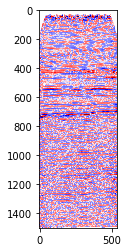

In [ ]:
plt.imshow(trace_data, cmap='seismic',interpolation='none') #plotting 2d array image with colormap 'seismic'
                                                            #with no interpolation (2d array to plot figure size)

---
Well, but that's not quite good to look at.
Let's make it prettier.

First make the y-axis array by using `np.linspace`. 

**"what's that np.linspace(a,b,n)?"**

>For some who don't know what linspace is, just like in matlab, you can make 1D array from `a` to `b` with `n` samples. For example `np.linspace(0,3,4)` makes [0, 1, 2, 3].

---

In [ ]:
t_seis=np.linspace(0,float(dt_sample*1e-6)*(tr_sample-1),tr_sample) #making the time axis using linspace (see doc)
print(t_seis)

[0.000e+00 4.000e-03 8.000e-03 ... 5.992e+00 5.996e+00 6.000e+00]


---
Then let's put it all on the plot figure.

---

Text(0.5, 1.0, '31_81_PR.SGY')

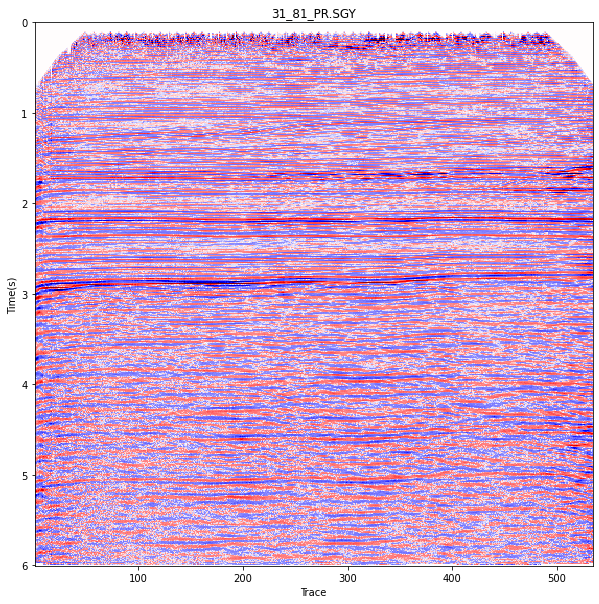

In [ ]:
plt.figure(figsize = (10,10))                                     #setting the size of the figure
plt.imshow(trace_data, aspect='auto', cmap='seismic', 
           interpolation='none', 
           extent=[1,n_trace,float(dt_sample*1e-6)*tr_sample,0])  #the axis of imshow [xmin,xmax,ymax,ymin]
plt.xlabel('Trace')
plt.ylabel('Time(s)')
plt.title(filename)

#**WRAPPING UP!** Let's Put it on a function

---
Alright, we understand how to parse all those important data and headers info, now we can summ it up into a **function**, which you can use it by calling a simple command everytime you need to fetch one or multiple SEGY file.

---



In [ ]:
def read_segy(filename):
  import numpy as np
  import os
  import struct

  f = open(filename, 'rb')                        

  f.seek(0,0)                 
  data = f.read(3200)         
  data = data.decode('cp500') 
  n = 80                      
  txt_header=[]               
  for i in range(0, len(data), n):  
    txt_header.append(data[i:i+n])        

  f.seek(3500,0)                                  
  data = f.read(1)                                
  segy_ver=int.from_bytes(data, byteorder='big')  
  f.seek(3504,0)                                  
  data = f.read(2)                                
  ext_header=int.from_bytes(data, byteorder='big')  
  f.seek(3216,0)                                  
  data = f.read(2)                               
  dt_sample=int.from_bytes(data, byteorder='big')  
  f.seek(3224,0)                                  
  data = f.read(2)                                
  data_format=int.from_bytes(data, byteorder='big')  
  f.seek(3220,0)                                  
  data = f.read(2)                                
  tr_sample=int.from_bytes(data, byteorder='big') 

  size_trace=file_size-3200-400
  n_trace=int(size_trace/(tr_sample*4+240))

  trace_header=np.zeros([75,n_trace],dtype=int)
  for i in range(0,n_trace):
    for j in range(0,75):
      off= int(trh_byte_pos[j,0])-1
      siz= int(trh_byte_pos[j,1]) 
      f.seek(3600+(off)+i*(tr_sample*4+240),0)
      temp=f.read(siz)
      trace_header[j,i]=int.from_bytes(temp, byteorder='big')

  trace_data=np.zeros([tr_sample,n_trace],dtype=float)                                                     
  for i in range(0,n_trace):
    for j in range(0,tr_sample):
      pos_bt=3600+240+(i*(tr_sample*4+240))+j*4
      f.seek(pos_bt,0)
      temp=f.read(4)
      if data_format==1:
        trace_data[j,i]=struct.unpack('>f',temp)[0]
      if data_format==2 or data_format==4:
        trace_data[j,i]=struct.unpack('>i',temp)[0]
  print("reading", filename, "is successful.")
  return txt_header, trace_header, trace_data, dt_sample

---
Let's try calling it by one line command bellow.

---

In [ ]:
txt_header, trace_header, trace_data,dt_sample = read_segy('31_81_PR.SGY')

reading 31_81_PR.SGY is successful.


---
Now, let's plot the seismic to test if its actually works.

---

Text(0.5, 1.0, '31_81_PR.SGY')

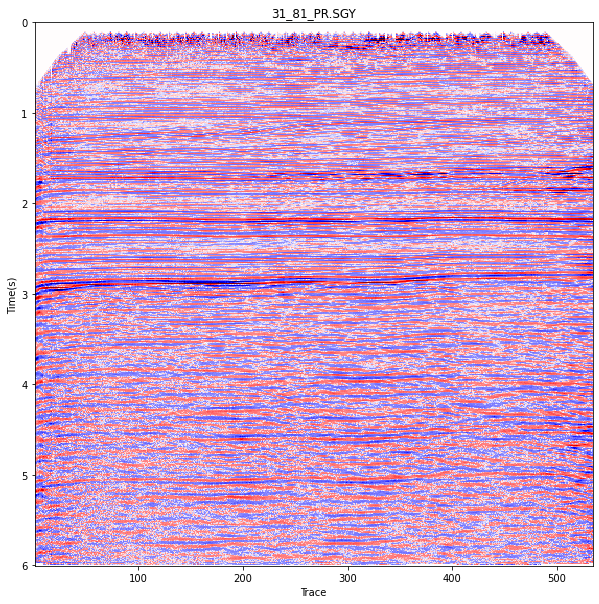

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(trace_data, aspect='auto', cmap='seismic', 
           interpolation='none', 
           extent=[1,trace_data.shape[1],float(dt_sample*1e-6)*trace_data.shape[0],0])
plt.xlabel('Trace')
plt.ylabel('Time(s)')
plt.title(filename)

---
Congratulation!

Good luck on experimenting your data now after understanding how to parse your seismic.

---

#**Exercises**


---
1. There's something not quite finished yet in handling when parsing the trace data from binary file. Can you find and modify it?
2. Try to put the trace data into a pandas format!
3. Try to experiment with the data! How about the data spectrum (use FFT)? Interpolation of missing/null traces?

---

In [ ]:
(code here)

SyntaxError: ignored